### **Step 1: Mounting google drive, defining the paths and installing necessary package.** 

In [1]:
#Mounting google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip install librosa


In [3]:
#define the path for test and train data
import pathlib
train_data_path=pathlib.Path('/content/gdrive/MyDrive/Audio detection/AudioDataset/train')
test_data_path=pathlib.Path('/content/gdrive/MyDrive/Audio detection/AudioDataset/Unlabelled')


In [4]:
#checking the number of data points
import os
print("Number of training sound clips:", len(list(train_data_path.glob('*/*.wav'))))
print("Number of testing sound clips:", len(os.listdir(test_data_path)))

Number of training sound clips: 47
Number of testing sound clips: 4


There are a total of 47 labelled sound clips and 4 test sound clips. 

## Step 2: Reading and analysing a random data point from both the classes.

In [5]:
#importing necessary libraries to read and display audio(wav) files
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd

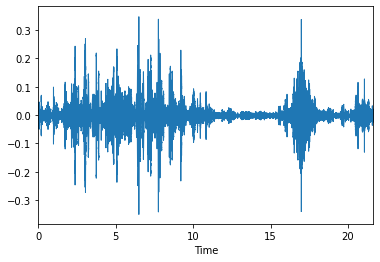

In [6]:

#displaying a sound clip from class PersonA
data_personA,sample_rate =librosa.load('/content/gdrive/MyDrive/Audio detection/AudioDataset/train/PersonA/STE-055_person A.wav')
librosa.display.waveplot(data_personA,sr=sample_rate)
ipd.Audio('/content/gdrive/MyDrive/Audio detection/AudioDataset/train/PersonA/STE-055_person A.wav')

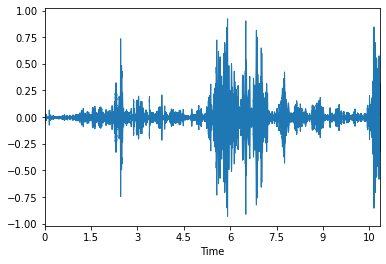

In [7]:
#displaying a sample from class PersonB
data_personB,sample_rate =librosa.load('/content/gdrive/MyDrive/Audio detection/AudioDataset/train/PersonB/STE-060_person B.wav')
librosa.display.waveplot(data_personB,sr=sample_rate)
ipd.Audio('/content/gdrive/MyDrive/Audio detection/AudioDataset/train/PersonB/STE-060_person B.wav')

## Step 3: Reading the data, extracting the features and prepare data for model building. 

In [8]:
#tabulating the filename and folder name (class)
import pandas as pd
train_data = []
for folder in sorted(os.listdir(train_data_path)):
    for file in sorted(os.listdir(train_data_path / folder)):
        if file != '.DS_Store':
          train_data.append((folder, file))
        
df = pd.DataFrame(train_data, columns=['Classname', 'Filename'])
df.head()



Classname              Filename
0   PersonA  STE-054_person A.wav
1   PersonA  STE-055_person A.wav
2   PersonA  STE-056_person A.wav
3   PersonA  STE-057_person A.wav
4   PersonA  STE-058_person A.wav

In [9]:
#function to extract features - Mel Frequency Cepstrum Coefficients
import numpy as np
def feature_extractor(file):
  audio, SR =librosa.load(file,res_type='kaiser_fast')
  mfccs_features=librosa.feature.mfcc(y=audio, sr=SR,n_mfcc=40)
  mfccs_scaled=np.mean(mfccs_features.T,axis=0)
  return mfccs_scaled

In [10]:
#Extracting MFCC for train data and assigning it to a dataframe
from tqdm import tqdm
features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name =os.path.join(os.path.abspath(train_data_path),str(row["Classname"])+'/',str(row["Filename"]))
    final_class_labels=row["Classname"]
    data=feature_extractor(file_name)
    features.append([data,final_class_labels])

47it [00:34,  1.37it/s]


In [11]:
#features dataframe
features_df=pd.DataFrame(features,columns=['feature','class'])
features_df.head()

feature    class
0  [-364.79764, 70.00277, 16.495731, 15.732025, 7...  PersonA
1  [-431.3119, 71.106995, 9.476123, 22.520226, 4....  PersonA
2  [-384.25473, 48.217823, 21.35579, 20.524864, 9...  PersonA
3  [-371.01843, 86.00609, 2.8843372, 18.956692, -...  PersonA
4  [-371.87173, 72.83965, 15.485067, 17.328537, 4...  PersonA

In [12]:
#defining X(input) and y(target)
X=np.array(features_df['feature'].tolist())
y=np.array(features_df['class'].tolist())

In [13]:
#importing necessary libraries to prepare data 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [14]:
X.shape

(47, 40)

In [15]:
y.shape

(47, 2)

In [16]:
num_labels=y.shape[1]


There are total of 40 features(MFF coefficients) extracted for every audio clip and 2 target classes.

## Step 4: Model Building and Training

In [17]:
#importing necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [18]:
#splitting train data to train and validation set
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)


In [19]:
#Model 1 - ANN
model=Sequential()
###first layer
model.add(Dense(30,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(75))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###fourth layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1230      
_________________________________________________________________
activation (Activation)      (None, 30)                0         
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)                3

In [21]:
#define loss, metrics and optimizer and compile the model
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')


In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from datetime import datetime 

num_epochs = 150
num_batch_size = 12
#defining checkpoints
checkpointer = ModelCheckpoint(filepath='/content/gdrive/MyDrive/Audio detection/Saved model.hdf5', 
                               verbose=1, save_best_only=True)
LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.40, patience = 2, 
                       verbose = 1, mode = 'min', min_lr = 0.001) 
callbacks_list = [checkpointer, LR]
start = datetime.now()
#training Model -1
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/150
4/4 [==============================] - 0s 19ms/step - loss: 0.3906 - accuracy: 0.8649 - val_loss: 0.5237 - val_accuracy: 0.9000

Epoch 00001: val_loss improved from inf to 0.52374, saving model to /content/gdrive/MyDrive/Audio detection/Saved model.hdf5
Epoch 2/150
4/4 [==============================] - 0s 9ms/step - loss: 0.4433 - accuracy: 0.8108 - val_loss: 0.5266 - val_accuracy: 0.9000

Epoch 00002: val_loss did not improve from 0.52374
Epoch 3/150
4/4 [==============================] - 0s 9ms/step - loss: 0.4488 - accuracy: 0.7838 - val_loss: 0.5249 - val_accuracy: 0.9000

Epoch 00003: val_loss did not improve from 0.52374
Epoch 4/150
4/4 [==============================] - 0s 9ms/step - loss: 0.3727 - accuracy: 0.8649 - val_loss: 0.5240 - val_accuracy: 0.9000

Epoch 00004: val_loss did not improve from 0.52374
Epoch 5/150
4/4 [==============================] - 0s 9ms/step - loss: 0.4423 - accuracy: 0.8919 - val_loss: 0.5201 - val_accuracy: 0.9000

Epoch 00005: val_loss

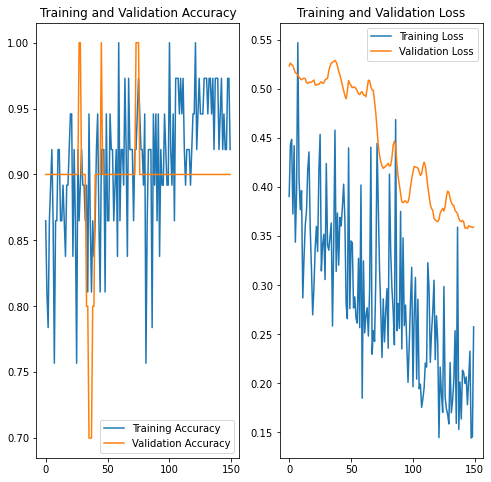

In [32]:
#visualizing the training/ validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
#function to test unlabelled data 
def test(path):
  feature_test=feature_extractor(path)
  feature_test=feature_test.reshape(1,-1)
  predicted=model.predict(feature_test)
  predicted[predicted >= 0.5] = 1
  predicted[predicted < 0.5] = 0
  if predicted[0,0] ==0. and predicted[0,1] ==1.:
     label="PersonB"
  else:
    label="PersonA"
  return label

## Step 5: Testing the unlabelled data

In [34]:
test("/content/gdrive/MyDrive/Audio detection/AudioDataset/Unlabelled/TestFootstepRecording_01.wav")


'PersonB'

In [35]:
test("/content/gdrive/MyDrive/Audio detection/AudioDataset/Unlabelled/TestFootstepRecording_02.wav")

'PersonB'

In [36]:
test("/content/gdrive/MyDrive/Audio detection/AudioDataset/Unlabelled/TestFootstepRecording_03.wav")


'PersonA'

In [37]:
test("/content/gdrive/MyDrive/Audio detection/AudioDataset/Unlabelled/TestFootstepRecording_04.wav")


'PersonA'

# Observations and Future Scope



1.   Due to very few samples we cannot conclude the results predicted. The model performance can be improved by adding more layers and data points
2.   Can explore extracting other properties of a sound waves like spectrogram/ PSD etc.

1.  1D convolution model can be built.
2.  Other features extracted can be visualized as images and 2D convolution models can be built. 

5.  The soundclips have noise and of uneven length. A few preprocessing steps can be used to tackle that.














